# **PYMUPDF**

In [1]:
pip install PyMuPDF

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.1/24.1 MB 50.7 MB/s eta 0:00:00


In [3]:
import fitz  # This is the PyMuPDF library
import json
import os

def extract_text_with_bboxes(pdf_path: str) -> list:
    """
    Extracts text and its corresponding bounding box from each page of a PDF.

    Args:
        pdf_path (str): The file path to the PDF document.

    Returns:
        list: A list of dictionaries, where each dictionary represents a
              word and contains its text and bounding box coordinates.
              Returns an empty list if the file is not found.
    """
    # Check if the file exists before proceeding
    if not os.path.exists(pdf_path):
        print(f"Error: File not found at '{pdf_path}'")
        return []

    # Open the PDF document
    doc = fitz.open(pdf_path)
    all_words_data = []

    print(f"Processing {len(doc)} page(s) from '{pdf_path}'...")

    # Iterate through each page of the document
    for page_num, page in enumerate(doc):
        # Use get_text("words") to extract individual words and their coordinates
        # The output is a list of tuples: (x0, y0, x1, y1, "word", block_no, line_no, word_no)
        words_on_page = page.get_text("words")

        for word_info in words_on_page:
            # Extract the required information from the tuple
            x0, y0, x1, y1, text = word_info[:5]

            # Create a dictionary for the current word
            word_data = {
                "text": text,
                "bbox": [round(coord, 2) for coord in (x0, y0, x1, y1)]
            }
            all_words_data.append(word_data)

    # Close the document to free up resources
    doc.close()

    print("Extraction complete.")
    return all_words_data

# --- Main execution block ---
if __name__ == "__main__":
    # Define the path to your PDF file
    pdf_file = "LenderFeesWorksheetNew.pdf"

    # Run the extraction function
    extracted_data = extract_text_with_bboxes(pdf_file)

    # If data was extracted, print it in a nicely formatted JSON structure
    if extracted_data:
        # Save the output to a JSON file for inspection
        output_filename = "extracted_data.json"
        with open(output_filename, "w") as f:
            json.dump(extracted_data, f, indent=2)

        print(f"\nSuccessfully extracted {len(extracted_data)} words.")
        print(f"Full output has been saved to '{output_filename}'.")

        # Print a small sample of the output to the console
        print("\n--- SAMPLE OUTPUT ---")
        print(json.dumps(extracted_data[:15], indent=2)) # Displaying first 15 items
        print("---------------------\n")

Processing 1 page(s) from 'LenderFeesWorksheetNew.pdf'...
Extraction complete.

Successfully extracted 404 words.
Full output has been saved to 'extracted_data.json'.

--- SAMPLE OUTPUT ---
[
  {
    "text": "Your",
    "bbox": [
      36.0,
      26.1,
      60.94,
      38.32
    ]
  },
  {
    "text": "actual",
    "bbox": [
      63.95,
      26.1,
      95.6,
      38.32
    ]
  },
  {
    "text": "rate,",
    "bbox": [
      98.61,
      26.1,
      121.74,
      38.32
    ]
  },
  {
    "text": "payment,",
    "bbox": [
      124.75,
      26.1,
      172.83,
      38.32
    ]
  },
  {
    "text": "and",
    "bbox": [
      175.83,
      26.1,
      195.3,
      38.32
    ]
  },
  {
    "text": "cost",
    "bbox": [
      198.31,
      26.1,
      220.82,
      38.32
    ]
  },
  {
    "text": "could",
    "bbox": [
      223.83,
      26.1,
      253.04,
      38.32
    ]
  },
  {
    "text": "be",
    "bbox": [
      256.04,
      26.1,
      268.82,
      38.32
    ]
  },
  {

In [4]:
if __name__ == "__main__":
    # Define the path to your PDF file
    pdf_file = "/content/LenderFeesWorksheetNew.pdf"

    # Run the extraction function
    extracted_data = extract_text_with_bboxes(pdf_file)

    # ... rest of the script

Processing 1 page(s) from '/content/LenderFeesWorksheetNew.pdf'...
Extraction complete.


# TESSERACT OCR

In [5]:
pip install pytesseract pillow opencv-python PyMuPDF

In [8]:
import fitz  # PyMuPDF
import cv2
import pytesseract
import json
import re
from PIL import Image
import io

def preprocess_image(image_bytes):
    """
    Converts image bytes to an OpenCV image and applies preprocessing.
    """
    # Load image from bytes into an OpenCV object
    nparr = np.frombuffer(image_bytes, np.uint8)
    img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding for cleaner text
    processed_img = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    return processed_img

def find_value_after_anchor(ocr_data, anchor_phrase, num_words=2):
    """
    Finds an anchor phrase and extracts the next few words on the same line.
    This is useful for patterns like 'Mortgagor is [Name]'.
    """
    full_text = " ".join(ocr_data['text'])

    # Find the starting position of the anchor phrase
    try:
        start_index = full_text.split().index(anchor_phrase.split()[0])
    except ValueError:
        return None, None

    # Check if the full phrase matches
    phrase_len = len(anchor_phrase.split())
    if " ".join(ocr_data['text'][start_index : start_index + phrase_len]) != anchor_phrase:
        return None, None

    # Find the words after the anchor on the same line
    value_words = []
    line_num = ocr_data['line_num'][start_index]

    current_index = start_index + phrase_len
    while current_index < len(ocr_data['text']) and ocr_data['line_num'][current_index] == line_num and len(value_words) < num_words:
        word = ocr_data['text'][current_index]
        if word.strip():
            value_words.append(word)
        current_index += 1

    # Placeholder for bounding box - in a real scenario, you'd combine them
    bbox = [
        ocr_data['left'][current_index - 1],
        ocr_data['top'][current_index - 1],
        ocr_data['width'][current_index - 1],
        ocr_data['height'][current_index - 1]
    ]

    return " ".join(value_words), bbox

def find_pattern(ocr_data, pattern):
    """
    Finds a specific regex pattern in the OCR text.
    """
    for i, text in enumerate(ocr_data['text']):
        if re.match(pattern, text):
            bbox = [ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]]
            return text, bbox
    return None, None

def extract_information(ocr_data):
    """
    Applies rules to extract key fields from the OCR data dictionary.
    """
    extracted = {}

    # 1. Document Title
    # Look for a standalone "MORTGAGE" in all caps
    for i, text in enumerate(ocr_data['text']):
        if text.strip() == "MORTGAGE":
            extracted["document_title"] = {
                "text": text,
                "bounding_box": [ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]]
            }
            break

    # 2. Borrower Name
    borrower_name, borrower_bbox = find_value_after_anchor(ocr_data, "The Mortgagor is", 2)
    if borrower_name:
        extracted["borrower_name"] = {"text": borrower_name.replace(',', ''), "bounding_box": borrower_bbox}

    # 3. Lender Name (simplified search)
    lender_name, lender_bbox = find_value_after_anchor(ocr_data, "MERS M&I Bank", 1)
    if lender_name:
         extracted["lender_name"] = {"text": "M&I Bank " + lender_name, "bounding_box": lender_bbox}

    # 4. Loan Amount
    loan_amount, loan_bbox = find_pattern(ocr_data, r"\$[\d,]+\.\d{2}")
    if loan_amount:
        extracted["loan_amount"] = {"text": loan_amount, "bounding_box": loan_bbox}

    # 5. Loan Date
    loan_date, loan_bbox = find_value_after_anchor(ocr_data, "is given on", 3)
    if loan_date:
        extracted["loan_date"] = {"text": loan_date, "bounding_box": loan_bbox}

    # 6. Recording Date
    rec_date, rec_bbox = find_value_after_anchor(ocr_data, "RECORDED", 1)
    if rec_date:
        extracted["recording_date"] = {"text": rec_date, "bounding_box": rec_bbox}

    # 7. Property Address (simplified)
    address, address_bbox = find_value_after_anchor(ocr_data, "address of", 4)
    if address:
        extracted["property_address"] = {"text": address, "bounding_box": address_bbox}

    return extracted

def main(pdf_path):
    """
    Main function to run the entire OCR and extraction pipeline.
    """
    # Step 1: Convert PDF's first page to an image
    doc = fitz.open(pdf_path)
    page = doc[0]
    pix = page.get_pixmap(dpi=300) # Higher DPI for better quality
    image_bytes = pix.tobytes("png")
    doc.close()

    # Step 2: Preprocess the image
    processed_image = preprocess_image(image_bytes)

    # Step 3: Run Tesseract OCR
    # Using image_to_data to get text along with bounding boxes and other info
    ocr_data = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DICT)

    # Step 4: Extract structured information using custom rules
    structured_data = extract_information(ocr_data)

    # Step 5: Print the final JSON output
    print(json.dumps(structured_data, indent=4))


# --- Script Execution ---
if __name__ == "__main__":
    import numpy as np # OpenCV dependency

    pdf_file = "/content/MTG_10009588.pdf"
    main(pdf_file)

{
    "document_title": {
        "text": "MORTGAGE",
        "bounding_box": [
            1119,
            197,
            319,
            78
        ]
    },
    "loan_amount": {
        "text": "$112,084.00",
        "bounding_box": [
            1630,
            1766,
            205,
            29
        ]
    }
}


# ALL 3 *METHODS*

# ## üìã Table of Contents
# 1. [Installation](#installation)
# 2. [Basic Setup](#setup)
# 3. [PDF to Image Conversion](#pdf-conversion)
# 4. [OCR Processing](#ocr-processing)
# 5. [Results Visualization](#visualization)
# 6. [Advanced Features](#advanced)

---



In [ ]:
# Install PaddleOCR and dependencies
!pip install paddleocr
!pip install paddlepaddle



print("‚úÖ All packages installed successfully!")

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 72.4/72.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48.2/48.2 kB 1.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 63.3/63.3 kB 2.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.7/1.7 MB 25.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.0/1.0 MB 28.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2.3/2.3 MB 53.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 192.8/192.8 MB 6.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: opt_einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.


In [ ]:
# Install PDF processing tools
!pip install pdf2image
!apt-get install poppler-utils -y  # Required for pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (738 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


## üîß 2. Basic Setup
Import libraries and set up the environment

In [ ]:
# Import required libraries
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pdf2image import convert_from_path
import os
from google.colab import files
import io

In [ ]:
# Upload your PDF file
print("üìÅ Upload your PDF file:")
uploaded = files.upload()

üìÅ Upload your PDF file:


Saving LenderFeesWorksheetNew-1.pdf to LenderFeesWorksheetNew-1.pdf


In [ ]:
# Get the uploaded file name
pdf_filename = list(uploaded.keys())[0]
pdf_path = f"/content/{pdf_filename}"
print(f"‚úÖ File uploaded: {pdf_filename}")

‚úÖ File uploaded: LenderFeesWorksheetNew-1.pdf


---
## üñºÔ∏è 3. PDF to Image Conversion {#pdf-conversion}
Convert PDF pages to images for OCR processing

In [ ]:
# Convert PDF to images
def convert_pdf_to_images(pdf_path, dpi=300):
    """
    Convert PDF pages to images

    Args:
        pdf_path (str): Path to PDF file
        dpi (int): Resolution for conversion (higher = better quality, larger file)

    Returns:
        list: List of PIL Image objects
    """
    try:
        images = convert_from_path(pdf_path, dpi=dpi)
        print(f"‚úÖ Successfully converted {len(images)} page(s)")
        return images
    except Exception as e:
        print(f"‚ùå Error converting PDF: {e}")
        return []



In [ ]:
# Convert the uploaded PDF
images = convert_pdf_to_images(pdf_path)

‚úÖ Successfully converted 1 page(s)


In [ ]:
# Display converted pages
def display_pdf_pages(images, max_pages=3):
    """Display the first few pages of the converted PDF"""
    pages_to_show = min(len(images), max_pages)

    fig, axes = plt.subplots(1, pages_to_show, figsize=(5*pages_to_show, 7))
    if pages_to_show == 1:
        axes = [axes]

    for i in range(pages_to_show):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Page {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()



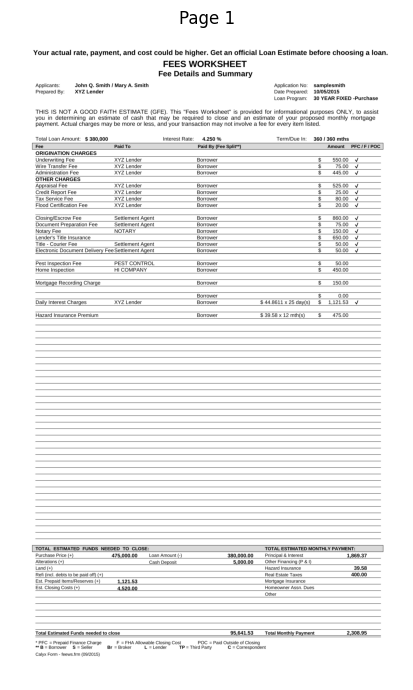

In [ ]:
if images:
    display_pdf_pages(images)
else:
    print("‚ùå No images to display")

---
## üîç 4. OCR Processing {#ocr-processing}
Initialize PaddleOCR and process the images

In [ ]:
# Initialize PaddleOCR
def initialize_ocr(language='en', use_gpu=False):
    """
    Initialize PaddleOCR with specified settings

    Args:
        language (str): Language code ('en', 'ch', 'fr', etc.)
        use_gpu (bool): Whether to use GPU acceleration

    Returns:
        PaddleOCR: Initialized OCR object
    """
    try:
        ocr = PaddleOCR(
            use_textline_orientation=True,  # Enable text angle classification
            lang=language,       # Set language
        )
        print(f"‚úÖ PaddleOCR initialized for language: {language}")
        return ocr
    except Exception as e:
        print(f"‚ùå Error initializing OCR: {e}")
        return None

In [ ]:
# Initialize OCR
ocr = initialize_ocr('en')

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_doc_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_doc_ori_infer.tar
[==================================================] 100.00%


/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/UVDoc_infer.tar ...
[==================================================] 100.00%
Extracting UVDoc_infer.tar
[==================================================] 100.00%


Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_textline_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_textline_ori_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_server_det_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_server_det_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_server_rec_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_server_rec_infer.tar
[==================================================] 100.00%
‚úÖ PaddleOCR initialized for language: en


In [ ]:
# Process images with OCR
def process_image_ocr(ocr, image, page_num=1):
    """
    Process a single image with OCR

    Args:
        ocr: PaddleOCR object
        image: PIL Image object
        page_num (int): Page number for identification

    Returns:
        tuple: (results, processed_image_path)
    """
    # Save image temporarily
    img_path = f'/content/page_{page_num}.png'
    image.save(img_path, 'PNG')

    # Perform OCR
    try:
        result = ocr.ocr(img_path)
        print(f"‚úÖ OCR completed for page {page_num}")
        return result, img_path
    except Exception as e:
        print(f"‚ùå OCR error for page {page_num}: {e}")
        return None, img_path

In [ ]:
# Process all pages
all_results = []
all_image_paths = []

for i, image in enumerate(images):
    result, img_path = process_image_ocr(ocr, image, i+1)
    all_results.append(result)
    all_image_paths.append(img_path)

<ipython-input-15-633010084>:20: DeprecationWarning: Please use `predict` instead.
  result = ocr.ocr(img_path)
Resized image size (4200x2550) exceeds max_side_limit of 4000. Resizing to fit within limit.


‚úÖ OCR completed for page 1


---
## üìä 5. Results Visualization {#visualization}
Visualize OCR results with bounding boxes and extracted text

In [ ]:
# Visualization functions
def parse_ocr_result(ocr_result):
    """
    Parse OCR result and extract boxes, texts, and scores safely
    Handle both old format and new dictionary format

    Args:
        ocr_result: OCR results from PaddleOCR

    Returns:
        tuple: (boxes, texts, scores) or (None, None, None) if no valid results
    """
    if not ocr_result:
        return None, None, None


    # Handle list containing dictionary (newer PaddleOCR format)
    if isinstance(ocr_result, list) and len(ocr_result) > 0:
        first_element = ocr_result[0]

        # If first element is a dictionary, extract from it
        if isinstance(first_element, dict):

            if 'rec_texts' in first_element and 'rec_scores' in first_element and 'rec_polys' in first_element:
                boxes = first_element['rec_polys']
                txts = first_element['rec_texts']
                scores = first_element['rec_scores']

                return boxes, txts, scores
            else:
                return None, None, None

        # Handle traditional list format [[box, [text, score]], ...]
        elif isinstance(first_element, list):

            boxes = []
            txts = []
            scores = []

            for i, line in enumerate(ocr_result[0]):
                try:
                    if len(line) >= 2:
                        box = line[0]  # Bounding box coordinates

                        # Check if line[1] is a tuple/list with text and score
                        if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
                            txt = line[1][0]  # Text
                            score = line[1][1]  # Confidence score
                        elif isinstance(line[1], str):
                            txt = line[1]
                            score = 1.0  # Default score
                        else:
                            continue

                        boxes.append(box)
                        txts.append(txt)
                        scores.append(score)

                except Exception as e:
                    print(f"Error parsing line {i}: {e}")
                    continue

            return boxes, txts, scores

    # Handle direct dictionary format
    elif isinstance(ocr_result, dict):

        if 'rec_texts' in ocr_result and 'rec_scores' in ocr_result and 'rec_polys' in ocr_result:
            boxes = ocr_result['rec_polys']
            txts = ocr_result['rec_texts']
            scores = ocr_result['rec_scores']

            return boxes, txts, scores
        else:

            return None, None, None

    print("Debug - Unrecognized OCR result format")
    return None, None, None

def draw_ocr_results(image_path, ocr_result):
    """
    Draw bounding boxes and text on the image

    Args:
        image_path (str): Path to the image file
        ocr_result: OCR results from PaddleOCR

    Returns:
        tuple: (annotated_image, boxes, txts, scores) or None if no results
    """
    boxes, txts, scores = parse_ocr_result(ocr_result)

    if not boxes:
        print("No valid OCR results to draw")
        return None

    # Load image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)


    # Draw bounding boxes and text
    for i, (box, txt, score) in enumerate(zip(boxes, txts, scores)):
        if score > 0.5:  # Lowered threshold to see more results
            try:


                # Handle different box formats
                if isinstance(box, np.ndarray):
                    # Convert numpy array to list for easier handling
                    box_points = box.tolist()
                else:
                    box_points = box

                # Ensure we have 4 corner points
                if len(box_points) >= 4:
                    # PaddleOCR typically returns 4 corner points: [top-left, top-right, bottom-right, bottom-left]
                    # Each point is [x, y]
                    if isinstance(box_points[0], (list, tuple, np.ndarray)) and len(box_points[0]) == 2:
                        # Format: [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
                        corners = [(int(point[0]), int(point[1])) for point in box_points[:4]]
                    else:
                        # Flatten format: [x1,y1,x2,y2,x3,y3,x4,y4]
                        flat_coords = box_points[:8]  # Take first 8 coordinates
                        corners = [(int(flat_coords[j]), int(flat_coords[j+1])) for j in range(0, 8, 2)]


                    # Draw the polygon (quadrilateral bounding box)
                    if len(corners) >= 4:
                        # Draw lines between consecutive corners and close the shape
                        for j in range(len(corners)):
                            start_point = corners[j]
                            end_point = corners[(j + 1) % len(corners)]  # Wrap around to first point
                            draw.line([start_point, end_point], fill='red', width=2)

                        # Add confidence score at top-left corner
                        try:
                            font = ImageFont.load_default()
                            text_x, text_y = corners[0]  # Use first corner (typically top-left)
                            draw.text((text_x, text_y - 15), f"{score:.2f}", fill='blue', font=font)
                        except Exception as font_error:
                            print(f"Font error: {font_error}")
                            pass
                    else:
                        print(f"Warning - Not enough corners for box {i}: {len(corners)}")
                else:
                    print(f"Warning - Box {i} doesn't have enough points: {len(box_points)}")

            except Exception as e:
                print(f"Error drawing box {i} for text '{txt[:20]}': {e}")
                print(f"Box data: {box}")
                continue

    return image, boxes, txts, scores

def display_ocr_results(image_path, ocr_result, page_num):
    """Display original image and OCR results side by side"""
    print(f"Starting visualization for page {page_num}")

    result_data = draw_ocr_results(image_path, ocr_result)

    if result_data is None:
        print(f"‚ùå No text detected on page {page_num}")
        return None, None, None

    annotated_image, boxes, txts, scores = result_data
    original_image = Image.open(image_path)

    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(original_image)
    ax1.set_title(f'Original - Page {page_num}')
    ax1.axis('off')

    ax2.imshow(annotated_image)
    ax2.set_title(f'OCR Results - Page {page_num} ({len(txts)} items found)')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return boxes, txts, scores



Starting visualization for page 1


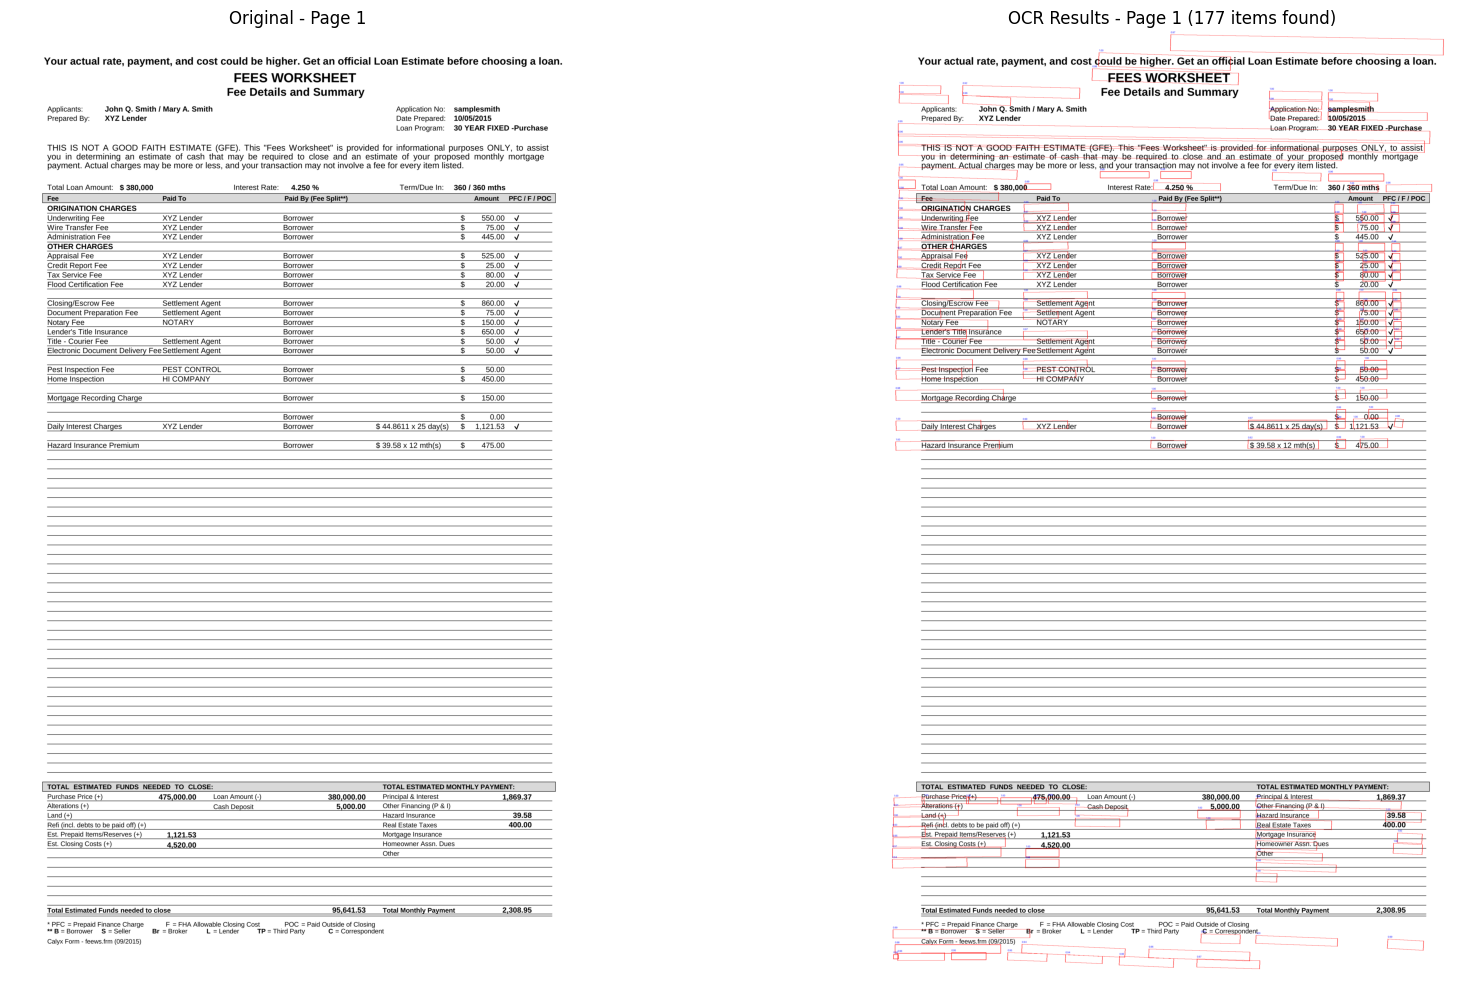


üîç Total text segments extracted: 177

üìã All Extracted Text:
  1. Get an official Loan Estimate before choosing a loan.
  2. FEESWORKSHEET
  3. Fee Details and Summary
  4. Applicants:
  5.  John Q. Smith / Mary A. Smith
  6. Application No:
  7. Prepared By:
  8. samplesmith
  9. XYZ Lender
 10. Date Prepared:
 11. 10/05/2015
 12. Loan Program:
 13. 30 YEAR FIXED -Purchase
 14. THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assit
 15. you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage
 16. payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
 17. Total Loan Amount: $ 380,000
 18. Interest Rate:
 19. 4.250 %
 20. Term/Due In:
 21. 360/360 mths
 22. Fee
 23. Paid To
 24. Paid By (Fee Split**)
 25. Amount
 26. PFC/F/POC
 27. ORIGINATION CHARGES
 28. Underwriting Fee
 29. XYZ Lender
 30. Borrower

In [ ]:
# Process and display results for each page
extracted_text_all = []

for i, (result, img_path) in enumerate(zip(all_results, all_image_paths)):
    page_num = i + 1

    # Check if we have any OCR results
    if result:
        try:
            # Display visualization
            visualization_result = display_ocr_results(img_path, result, page_num)

            if visualization_result[0] is not None:  # Check if visualization succeeded
                boxes, txts, scores = visualization_result

                # Extract and display text
                page_text = []


                for j, (txt, score) in enumerate(zip(txts, scores)):
                    if score > 0.3:  # Lowered threshold to see more results
                        page_text.append(txt)

                extracted_text_all.extend(page_text)

            else:
                print(f"‚ùå Failed to process OCR results for page {page_num}")

        except Exception as e:
            print(f"‚ùå Error processing page {page_num}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"‚ùå No OCR results for page {page_num}")

print(f"\nüîç Total text segments extracted: {len(extracted_text_all)}")

# Display all extracted text
if extracted_text_all:
    print(f"\nüìã All Extracted Text:")
    print("=" * 50)
    for i, text in enumerate(extracted_text_all, 1):
        print(f"{i:3d}. {text}")
else:
    print("‚ùå No text was extracted from any page")

---
# üåü Alternative: EasyOCR (Quick & Modern)

EasyOCR is a newer, more specialized OCR engine optimized for documents

## Install EasyOCR

In [ ]:
# Install specific compatible versions
# This combination is known to work well with SuryaOCR and transformers
!pip install easyocr

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ

In [ ]:
# Install
!pip install pdf2image
!apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 2s (123 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


## Import and setup EasyOCR

In [ ]:
# Upload PDF and convert to image
from google.colab import files
from pdf2image import convert_from_path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import easyocr


üìÅ Upload your PDF:


Saving LenderFeesWorksheetNew-1.pdf to LenderFeesWorksheetNew-1 (1).pdf


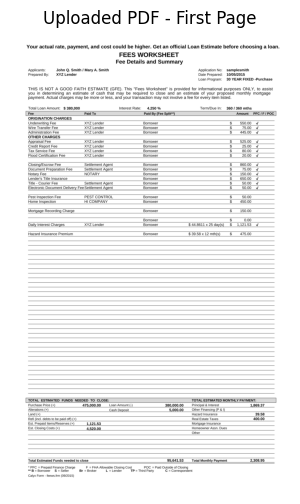

In [ ]:
# Upload PDF
print("üìÅ Upload your PDF:")
uploaded = files.upload()
pdf_path = f"/content/{list(uploaded.keys())[0]}"

# Convert to image
images = convert_from_path(pdf_path, dpi=300)
image = images[0]  # Use first page
# Save image as file (EasyOCR works better with file paths)
image_path = '/content/page.png'
image.save(image_path)

# Show uploaded image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title('Uploaded PDF - First Page')
plt.axis('off')
plt.show()

In [ ]:
# EasyOCR Processing
print("üîç Running EasyOCR...")

# Create reader (English)
reader = easyocr.Reader(['en'])

# Extract text
result = reader.readtext(image_path)

üîç Running EasyOCR...


In [ ]:
# Draw bounding boxes and extract text
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
extracted_text = []


for (bbox, text, confidence) in result:
    if confidence > 0.5:  # Filter by confidence
        # Draw bounding box
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        draw.rectangle([top_left, bottom_right], outline='red', width=2)

        # Add confidence score
        draw.text((top_left[0], top_left[1]-20), f"{confidence:.2f}", fill='red')

        extracted_text.append(text)

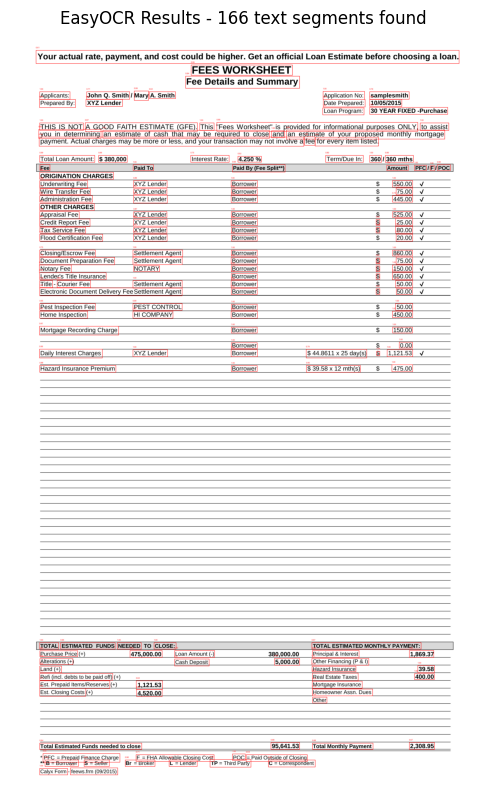

In [ ]:

# Display results
plt.figure(figsize=(15, 10))
plt.imshow(img_copy)
plt.title(f'EasyOCR Results - {len(extracted_text)} text segments found')
plt.axis('off')
plt.show()

In [ ]:
# Print extracted text
print(f"\nüìù Extracted Text ({len(extracted_text)} segments):")
print("-" * 50)
for i, text in enumerate(extracted_text, 1):
    print(f"{i:2d}. {text}")

print(f"\n‚úÖ EasyOCR completed successfully!")


üìù Extracted Text (166 segments):
--------------------------------------------------
 1. Your actual rate, payment; and cost could be higher. Get an official Loan Estimate before choosing a loan.
 2. FEES WORKSHEET
 3. Fee Details and Summary
 4. Applicants:
 5. John Q. Smith
 6. A. Smith
 7. Application No:
 8. samplesmith
 9. Prepared By:
10. XYZ Lender
11. Date Prepared:
12. 10/05/2015
13. Loan Program:
14. 30 YEAR FIXED -Purchase
15. THIS IS NOT
16. A GOOD FAITH ESTIMATE (GFE):
17. This
18. "Fees Worksheet" is provided for informational purposes ONLY,
19. to assist
20. you in determining
21. an estimate of cash that may be required to close
22. and
23. an estimate of your proposed monthly mortgage
24. payment: Actual charges may be more or less, and your transaction may not involve a
25. for every item listed:
26. Total Loan Amount:
27. $ 380,000
28. Interest Rate:
29. 4.250 %
30. TermlDue In:
31. 360
32. 360 mths
33. Fee
34. Paid To
35. Paid By (Fee_Splittt)
36. Amount
37. PFC
